Многоклассовая классификация твитов с использованием **CNN**

In [ ]:
!pip install pandas scikit-learn tensorflow nltk matplotlib seaborn


*   Для задач NLP используеися библиотека NLTK.

*   TensorFlow для машинного обучения. Слои Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout.



In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
# Загрузка датасета
print("Загрузка датасета...")
path = kagglehub.dataset_download("crowdflower/twitter-airline-sentiment")
csv_path = f"{path}/Tweets.csv"
df = pd.read_csv(csv_path)
data = df[['text', 'airline_sentiment']].copy()
data.columns = ['text', 'label']
print("Распределение классов до препроцессинга:")
print(data['label'].value_counts())

Загрузка датасета...
Распределение классов до препроцессинга:
label
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


In [ ]:
# Чистка данных
# Удаление пустых строк
data.dropna(inplace=True)
print(f"Количество строк после удаления NaN: {len(data)}")

# Инициализация лемматизатора и стоп-слов
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() # Приведение к нижнему регистру
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Удаление упоминаний (@username)
    text = re.sub(r'#', '', text) # Удаление символа хэштега (#)
    text = re.sub(r'rt[\s]+', '', text) # Удаление "RT"
    text = re.sub(r'https?://\S+', '', text) # Удаление URL-адресов
    text = re.sub(r'[^a-z\s]', '', text) # Удаление всего, кроме букв и пробелов
    text = text.split() # Токенизация по пробелам
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words] # Лемматизация и удаление стоп-слов
    text = ' '.join(text)
    return text

data['text'] = data['text'].apply(clean_text)

# Кодирование меток (Negative: 0, Neutral: 1, Positive: 2)
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
data['label'] = data['label'].map(label_mapping)
print("Распределение классов после препроцессинга:")
print(data['label'].value_counts())

Количество строк после удаления NaN: 14640


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Распределение классов после препроцессинга:
label
0    9178
1    3099
2    2363
Name: count, dtype: int64


In [ ]:
# Токенизация и векторизация

VOCAB_SIZE = 10000 # максимальное количество уникальных слов
MAX_LEN = 100 # Максимальная длина последовательности


tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
print(f"Количество уникальных токенов (слов) в словаре: {len(tokenizer.word_index)}")

Количество уникальных токенов (слов) в словаре: 11799


In [ ]:
# Паддинг
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
print(f"Форма паддинговых последовательностей: {padded_sequences.shape}")

Форма паддинговых последовательностей: (14640, 100)


Подготовка данных перед их подачей в модель машинного обучения. Определяем входные признаки (X) и метки классов (y).

In [ ]:
# Разделение датасета
X = padded_sequences
y = data['label'].values

# Разделение на обучающую + валидационную и тестовую выборки
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Разделение обучающей + валидационной выборки на обучающую (80%) и валидационную (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val) # 0.25 * 0.8 = 0.2 от общего датасета



print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (8784, 100)
Размер валидационной выборки: (2928, 100)
Размер тестовой выборки: (2928, 100)


Построение архитектуры

In [ ]:
# Построение модели CNN
embedding_dim = 100 # Размерность эмбеддингов

model = Sequential([
    # Входной слой (Embedding Layer)
    Embedding(VOCAB_SIZE + 1, embedding_dim, input_length=MAX_LEN),

    # Слои свертки и пулинга
    # Conv1D: 128 фильтров, размер ядра свертки 5. Это помогает обнаруживать n-граммы длиной до 5 слов.
    Conv1D(128, 5, activation='relu'),
    # GlobalMaxPooling1D: уменьшает размерность, выбирая максимальное значение из каждого фильтра, что помогает выделить наиболее важные признаки.
    GlobalMaxPooling1D(),

    # Полносвязный слой
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Выходной слой
    # 3 нейрона для 3 классов (negative, neutral, positive).
    # activation='softmax': для многоклассовой классификации, так как он выдает вероятности для каждого класса.
    Dense(3, activation='softmax')
])

print("Структура модели:")
model.summary()

Структура модели:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Компиляция модели

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Обучение модели
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/20
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6197 - loss: 0.8839
Epoch 1: val_accuracy improved from -inf to 0.75854, saving model to best_cnn_model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.6200 - loss: 0.8832 - val_accuracy: 0.7585 - val_loss: 0.6111
Epoch 2/20
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7889 - loss: 0.5598
Epoch 2: val_accuracy improved from 0.75854 to 0.77732, saving model to best_cnn_model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.7890 - loss: 0.5596 - val_accuracy: 0.7773 - val_loss: 0.5528
Epoch 3/20
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8676 - loss: 0.3742
Epoch 3: val_accuracy did not improve from 0.77732
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8676 - loss: 0.3741 - val_accuracy: 0.7766 - val_loss: 0.6077
Epoch 4/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9219 - loss: 0.2341
Epoch 4: val_accuracy did not improve from 0.77732
275/275 ━━

In [ ]:
# Оценка модели
loaded_model = tf.keras.models.load_model('best_cnn_model.keras') # Загрузка лучшей сохраненной модели
loss, accuracy = loaded_model.evaluate(X_test, y_test, verbose=0)
print(f"Точность на тестовом наборе: {accuracy:.4f}")
print(f"Потери на тестовом наборе: {loss:.4f}")

Точность на тестовом наборе: 0.7824
Потери на тестовом наборе: 0.5668


In [ ]:
# Вычисление метрик оценки
y_pred_probs = loaded_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

    negative       0.85      0.88      0.86      1835
     neutral       0.60      0.62      0.61       620
    positive       0.76      0.62      0.69       473

    accuracy                           0.78      2928
   macro avg       0.74      0.71      0.72      2928
weighted avg       0.78      0.78      0.78      2928



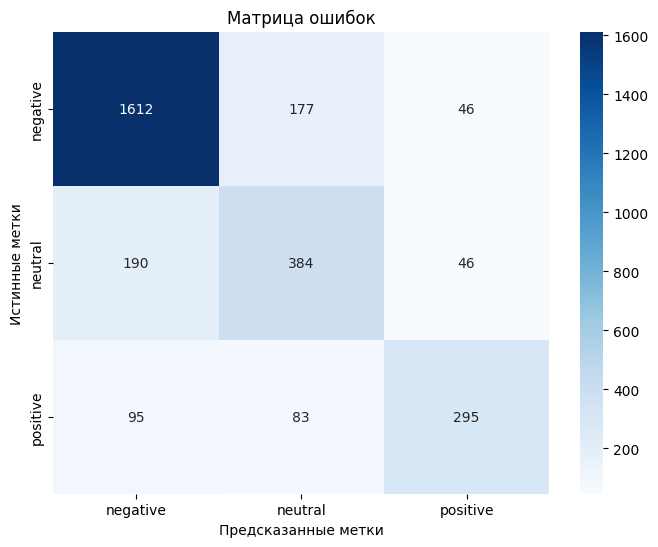

In [ ]:
# Визуализация результатов (матрица ошибок)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

Модель очень хорошо идентифицирует негативную тональность.

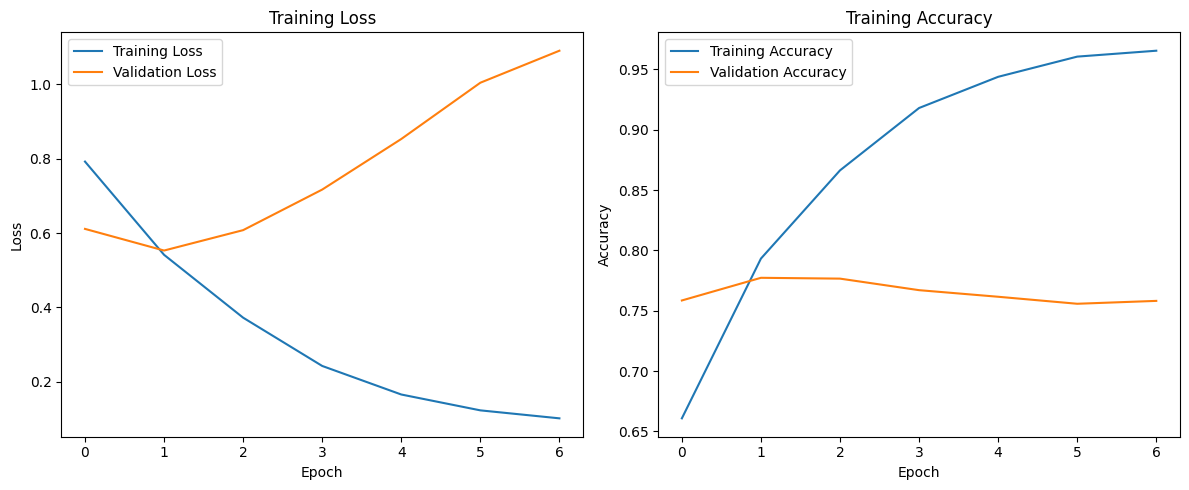

In [ ]:
# Визуализация потерь/точности обучения
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Т.к. модель ошибается с задачей выявления "positive" и "neutral" меток, добавим весы классов.

In [ ]:
neg_count = data['label'].value_counts()[0]
neu_count = data['label'].value_counts()[1]
pos_count = data['label'].value_counts()[2]
total_samples = len(data)

# Веса, обратно пропорциональные частоте класса
class_weights = {
    0: total_samples / (3 * neg_count), # Вес для 'negative'
    1: total_samples / (3 * neu_count), # Вес для 'neutral'
    2: total_samples / (3 * pos_count)  # Вес для 'positive'
}
print(f"Рассчитанные веса классов: {class_weights}")

Рассчитанные веса классов: {0: np.float64(0.5317062540858575), 1: np.float64(1.5747015166182639), 2: np.float64(2.0651713922979265)}


Еще я увеличила размерность эмбеддингов, использовала несколько сверточных слоев с разными размерами ядер (3, 5, 7). Коэффициент Dropout увеличен с 0.5 до 0.6 для усиления регуляризации. Опустила learning_rate=0.0005, чтобы уменьшить расхождения.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
import tensorflow as tf

embedding_dim = 150 # Увеличение размерности эмбеддингов

model = Sequential([
    Embedding(VOCAB_SIZE + 1, embedding_dim, input_length=MAX_LEN),

    # Добавлено несколько Conv1D слоев с разными размерами ядер для захвата различных n-грамм
    Conv1D(128, 3, activation='relu', padding='same'), # Новый слой: ядро 3, 'same' padding
    BatchNormalization(), # Добавлена нормализация батча
    Conv1D(128, 5, activation='relu', padding='same'), # Оригинальный слой, но с 'same' padding
    BatchNormalization(), # Добавлена нормализация батча
    Conv1D(128, 7, activation='relu', padding='same'), # Новый слой: ядро 7, 'same' padding
    BatchNormalization(), # Добавлена нормализация батча

    GlobalMaxPooling1D(),

    Dropout(0.6), # Увеличен Dropout
    Dense(64, activation='relu'),
    BatchNormalization(), # Добавлена нормализация батча
    Dropout(0.6), # Увеличен Dropout

    Dense(3, activation='softmax')
])

# Компиляция модели

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005) # Изменена скорость обучения

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучение модели
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True), # Увеличена patience
    tf.keras.callbacks.ModelCheckpoint('best_cnn_model_improved.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]

history = model.fit(X_train, y_train,
                    epochs=50, # Увеличено количество эпох
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks,
                    class_weight=class_weights) # Добавлены веса классов

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.3318 - loss: 1.9334
Epoch 1: val_accuracy improved from -inf to 0.16120, saving model to best_cnn_model_improved.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 54s 177ms/step - accuracy: 0.3319 - loss: 1.9327 - val_accuracy: 0.1612 - val_loss: 1.6862
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.3983 - loss: 1.4051
Epoch 2: val_accuracy improved from 0.16120 to 0.17657, saving model to best_cnn_model_improved.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 80s 169ms/step - accuracy: 0.3984 - loss: 1.4048 - val_accuracy: 0.1766 - val_loss: 1.5149
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5042 - loss: 0.9958
Epoch 3: val_accuracy improved from 0.17657 to 0.60417, saving model to best_cnn_model_improved.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 84s 175ms/step - accuracy: 0.5044 - loss: 0.9956 - val_accuracy: 0.6042 - val_loss: 0.9005
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6684 - loss: 0.7

Точность на тестовом наборе: 0.7531
Потери на тестовом наборе: 0.7934
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step

Отчет о классификации:
              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1835
     neutral       0.65      0.35      0.46       620
    positive       0.64      0.62      0.63       473

    accuracy                           0.75      2928
   macro avg       0.69      0.63      0.65      2928
weighted avg       0.74      0.75      0.73      2928



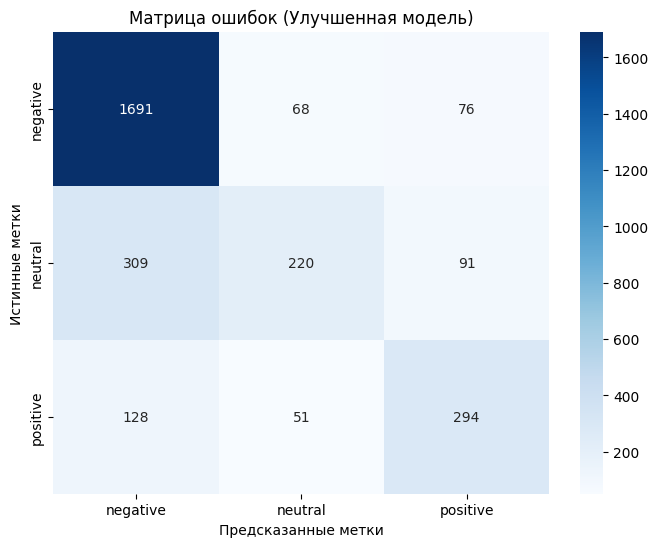

In [ ]:
# Оценка модели
loaded_model = tf.keras.models.load_model('best_cnn_model_improved.keras')
loss, accuracy = loaded_model.evaluate(X_test, y_test, verbose=0)
print(f"Точность на тестовом наборе: {accuracy:.4f}")
print(f"Потери на тестовом наборе: {loss:.4f}")

# Вычисление метрик оценки
y_pred_probs = loaded_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

# Визуализация результатов (матрица ошибок)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок (Улучшенная модель)')
plt.show()

 Теперь гораздо меньше отрицательных твитов ошибочно классифицируются как нейтральные, но больше отрицательных твитов теперь ошибочно классифицируются как положительные. Производительность для положительного класса осталась примерно на том же уровне по истинным предсказаниям, но модель стала чаще путать позитивные твиты с негативными, хотя и реже с нейтральными.

In [ ]:
# Сохранение модели
loaded_model.save('final_cnn_model_improved.keras')